# 2Day subsampling on the OceanColor Dataset

In [9]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm

## Load data from disk

We already downloaded a subsetted MODIS-Aqua chlorophyll-a dataset for the Arabian Sea.

We can read all the netcdf files into one xarray Dataset using the `open_mfsdataset` function. Note that this does not load the data into memory yet. That only happens when we try to access the values.

In [10]:
ds_8day = xr.open_mfdataset('./data_collector_modisa_chla9km/ModisA_Arabian_Sea_chlor_a_9km_*_8D.nc')
ds_daily = xr.open_mfdataset('./data_collector_modisa_chla9km/ModisA_Arabian_Sea_chlor_a_9km_*_D.nc')
both_datasets = [ds_8day, ds_daily]

How much data is contained here? Let's get the answer in MB.

In [11]:
print([(ds.nbytes / 1e6) for ds in both_datasets])

[534.295504, 4241.4716]


The 8-day dataset is ~534 MB while the daily dataset is 4.2 GB. These both easily fit in RAM. So let's load them all into memory

In [12]:
[ds.load() for ds in both_datasets]

[<xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 667)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
   * time           (time) datetime64[ns] 2002-07-04 2002-07-12 2002-07-20 ...
 Data variables:
     chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...
     palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...,
 <xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 5295)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 

## Fix bad data

In preparing this demo, I noticed that small number of maps had bad data--specifically, they contained large negative values of chlorophyll concentration. Looking closer, I realized that the land/cloud mask had been inverted. So I wrote a function to invert it back and correct the data.

In [13]:
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are chlorophyl values less than zero
    bad_data = ds.chlor_a.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.chlor_a[n].values 
        ds.chlor_a.values[n] = np.ma.masked_less(data, 0).filled(np.nan)

In [14]:
[fix_bad_data(ds) for ds in both_datasets]

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in less
  if not reflexive


[None, None]

In [15]:
ds_8day.chlor_a>0

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


<xarray.DataArray 'chlor_a' (time: 667, lat: 276, lon: 360)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., Fal

## Count the number of ocean data points

First we have to figure out the land mask. Unfortunately it doesn't come with the dataset. But we can infer it by counting all the points that have at least one non-nan chlorophyll value.

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


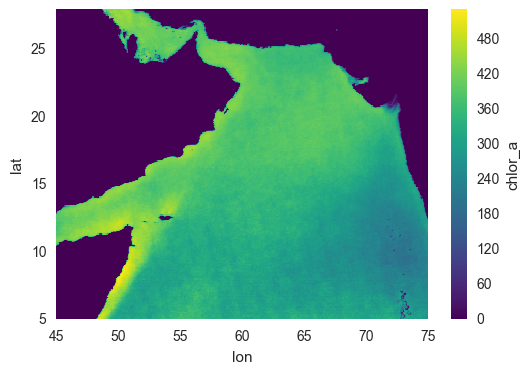

In [16]:
(ds_8day.chlor_a>0).sum(dim='time').plot()

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


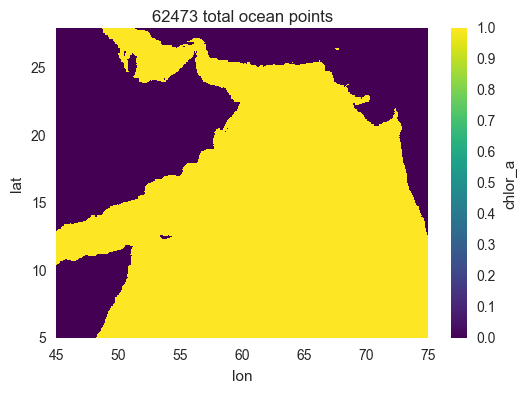

In [17]:
#  find a mask for the land
ocean_mask = (ds_8day.chlor_a>0).sum(dim='time')>0
#ocean_mask = (ds_daily.chlor_a>0).sum(dim='time')>0
num_ocean_points = ocean_mask.sum().values  # compute the total nonzeros regions(data point)
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

In [18]:
ds_8day

<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 667)
Coordinates:
  * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
  * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
  * rgb            (rgb) int64 0 1 2
  * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * time           (time) datetime64[ns] 2002-07-04 2002-07-12 2002-07-20 ...
Data variables:
    chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...

In [19]:
ds_daily

<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 5295)
Coordinates:
  * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
  * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
  * rgb            (rgb) int64 0 1 2
  * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * time           (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...
Data variables:
    chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


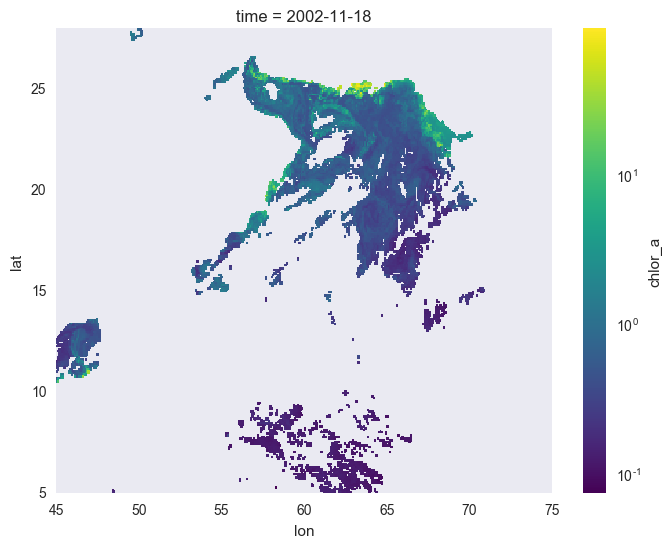

In [20]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time='2002-11-18',method='nearest').plot(norm=LogNorm())
#ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [21]:
list(ds_daily.groupby('time')) # take a look at what's inside

[(numpy.datetime64('2002-07-04T00:00:00.000000000'), <xarray.Dataset>
  Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3)
  Coordinates:
    * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
    * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
    * rgb            (rgb) int64 0 1 2
    * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
      time           datetime64[ns] 2002-07-04
  Data variables:
      chlor_a        (lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
      palette        (rgb, eightbitcolor) float64 -109.0 0.0 108.0 -112.0 0.0 ...),
 (numpy.datetime64('2002-07-05T00:00:00.000000000'), <xarray.Dataset>
  Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3)
  Coordinates:
    * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
    * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
    * rgb       

Now we count up the number of valid points in each snapshot and divide by the total number of ocean points.

In [22]:
'''
<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 144, lon: 276, rgb: 3, time: 4748)
'''
ds_daily.groupby('time').count() # information from original data

<xarray.Dataset>
Dimensions:  (time: 5295)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...
Data variables:
    chlor_a  (time) int64 658 1170 1532 2798 2632 1100 1321 636 2711 1163 ...
    palette  (time) int64 768 768 768 768 768 768 768 768 768 768 768 768 ...

In [23]:
ds_daily.chlor_a.groupby('time').count()/float(num_ocean_points)

<xarray.DataArray 'chlor_a' (time: 5295)>
array([ 0.01053255,  0.01872809,  0.02452259, ...,  0.        ,
        0.        ,  0.        ])
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...

In [26]:
count_8day, count_2day, count_daily = [ds.chlor_a.groupby('time').count()/float(num_ocean_points)
                            for ds in (ds_8day, ds_2day, ds_daily)]

In [27]:
#count_8day = ds_8day.chl_ocx.groupby('time').count()/float(num_ocean_points)
#coundt_daily = ds_daily.chl_ocx.groupby('time').count()/float(num_ocean_points)

#count_8day, coundt_daily = [ds.chl_ocx.groupby('time').count()/float(num_ocean_points)
#                            for ds in ds_8day, ds_daily] # not work in python 3


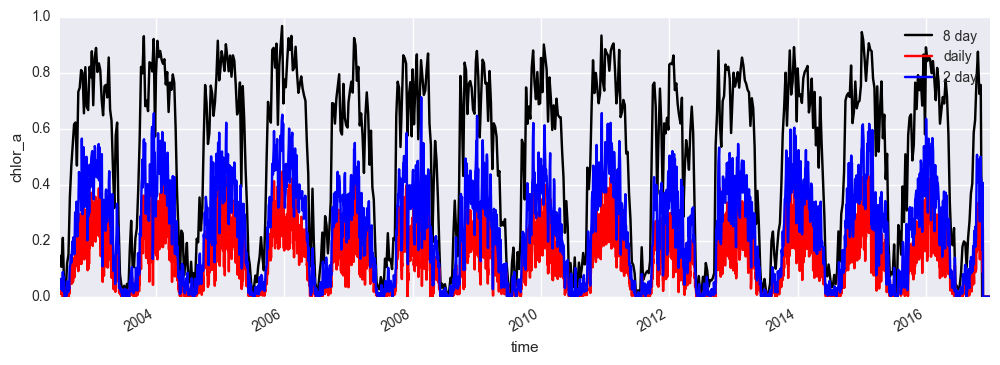

In [28]:
plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')
count_2day.plot(color='b')

plt.legend(['8 day','daily',  '2 day' ])

## Seasonal Climatology

In [29]:
count_8day_clim, coundt_daily_clim = [count.groupby('time.month').mean()  # monthly data
                                      for count in (count_8day, count_daily)]

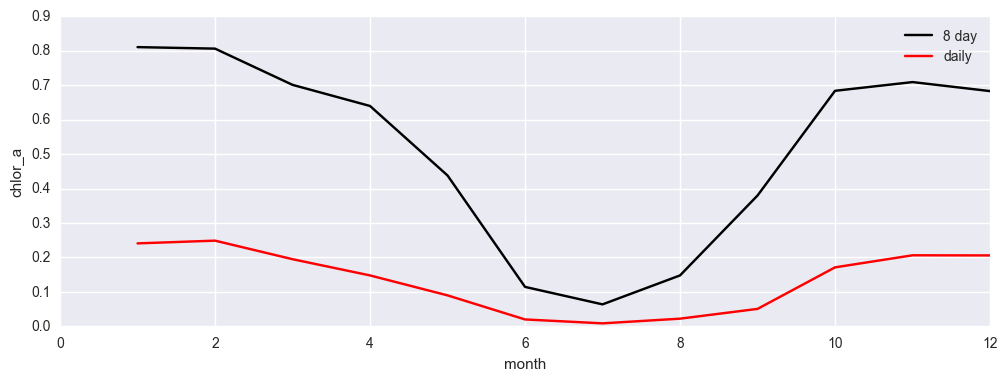

In [30]:
# mean value of the monthly data on the count of nonzeros
plt.figure(figsize=(12,4))
count_8day_clim.plot(color='k')
coundt_daily_clim.plot(color='r')
plt.legend(['8 day', 'daily'])

From the above figure, we see that data coverage is highest in the winter (especially Feburary) and lowest in summer.

## Maps of individual days

Let's grab some data from Febrauary and plot it.

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


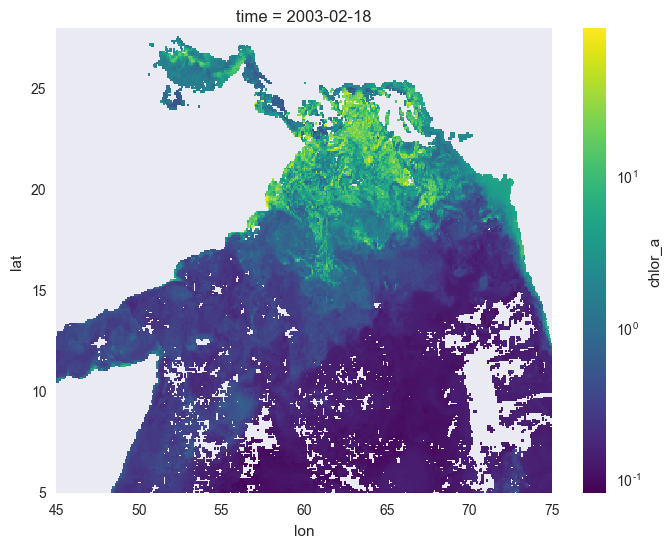

In [31]:
target_date = '2003-02-15'
plt.figure(figsize=(8,6))
ds_8day.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


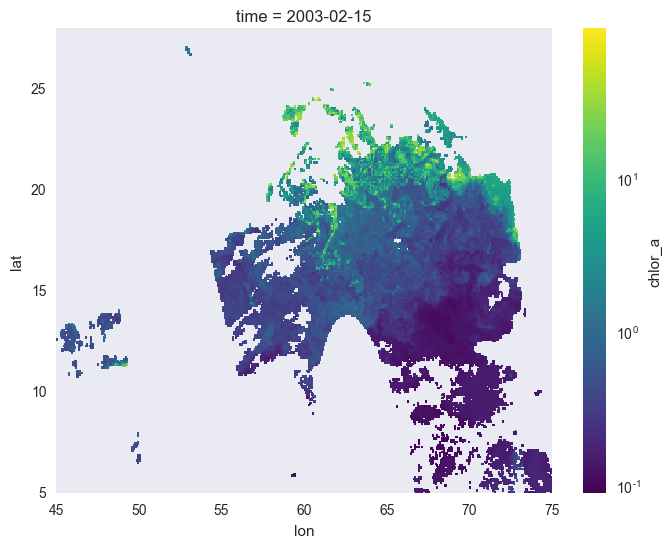

In [32]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [33]:
ds_daily.chlor_a[0].sel_points(lon=[65, 70], lat=[16, 18], method='nearest')   # the time is selected!
#ds_daily.chl_ocx[0].sel_points(time= times, lon=lons, lat=times, method='nearest')

<xarray.DataArray 'chlor_a' (points: 2)>
array([ nan,  nan])
Coordinates:
    time     datetime64[ns] 2002-07-04
    lat      (points) float64 16.04 18.04
    lon      (points) float64 65.04 70.04
  * points   (points) int64 0 1

In [34]:
ds_daily.chlor_a.sel_points?

In [35]:
ds_2day = ds_daily.resample('2D', dim='time')
ds_2day

<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 2648)
Coordinates:
  * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
  * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
  * rgb            (rgb) int64 0 1 2
  * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * time           (time) datetime64[ns] 2002-07-04 2002-07-06 2002-07-08 ...
Data variables:
    chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


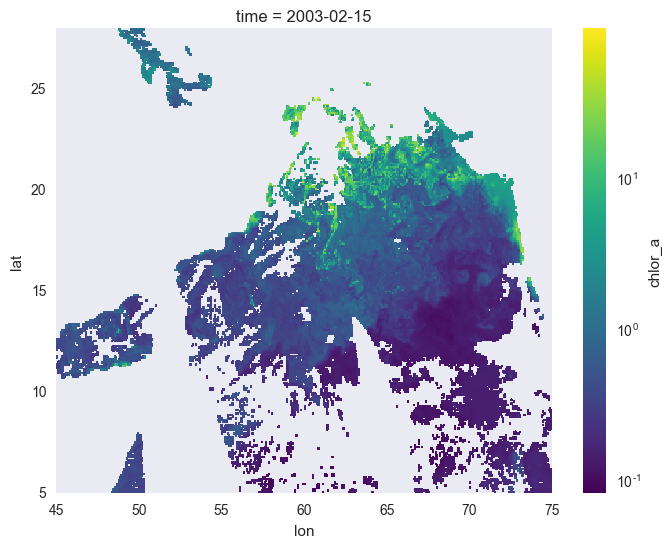

In [36]:
plt.figure(figsize=(8,6))
ds_2day.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [39]:
# check the range for the longitude
print(ds_2day.lon.min(),'\n' ,ds_2day.lat.min())  

<xarray.DataArray 'lon' ()>
array(45.04166793823242) 
 <xarray.DataArray 'lat' ()>
array(5.041661739349365)


# ++++++++++++++++++++++++++++++++++++++++++++++
# One GDP Floater
# Load the float data
# Map a (time, lon, lat) to a value on the cholorphlly value

In [40]:
# in the following we deal with the data from the gdp float
from buyodata  import buoydata
import os

In [41]:
# a list of files
#fnames = ['./gdp_float/buoydata_1_5000.dat','./gdp_float/buoydata_5001_10000.dat','./gdp_float/buoydata_10001_jun15.dat']
# not much data in the first file belong to Arabian Sea and after 2002-07-04 
fnames = ['./gdp_float/buoydata_1_5000.dat','./gdp_float/buoydata_5001_10000.dat']

# read them and cancatenate them into one DataFrame
df = pd.concat([buoydata.read_buoy_data(f) for f in fnames])  # around 4~5 minutes

In [42]:
df.head()

time       id    lat      lon    temp      ve      vn  \
0 1988-03-08 00:00:00  7702986 -1.320  274.848  25.473     NaN     NaN   
1 1988-03-08 06:00:00  7702986 -1.242  274.772  25.224 -49.214  36.778   
2 1988-03-08 12:00:00  7702986 -1.176  274.657  25.095 -57.514  28.439   
3 1988-03-08 18:00:00  7702986 -1.131  274.548  25.545 -48.625  28.747   
4 1988-03-09 00:00:00  7702986 -1.064  274.468  25.870 -50.787  34.399   

      spd   var_lat   var_lon   var_tmp  
0     NaN  0.000025  0.000034  0.004518  
1  61.438  0.000058  0.000087  0.007215  
2  64.161  0.000020  0.000026  0.005613  
3  56.487  0.000049  0.000072  0.005837  
4  61.340  0.000004  0.000006  0.003111

In [43]:
#mask = df.time>='2002-07-04' # we only have data after this data for cho_ocx
dfvv = df[df.time>='2002-07-04']

In [44]:
sum(dfvv.time<'2002-07-04') # recheck whether the time is 

0

In [45]:
# process the data so that the longitude are all >0
print('before processing, the minimum longitude is%f4.3 and maximum is %f4.3' % (dfvv.lon.min(),dfvv.lon.max()))
mask = dfvv.lon<0
dfvv.lon[mask] = dfvv.loc[mask].lon + 360
print('after processing, the minimum longitude is %f4.3 and maximum is %f4.3' % (dfvv.lon.min(),dfvv.lon.max()) )

before processing, the minimum longitude is0.0000004.3 and maximum is 360.0000004.3


/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


after processing, the minimum longitude is 0.0000004.3 and maximum is 360.0000004.3


/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/core/generic.py:4695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
dfvv.describe()

id           lat           lon          temp            ve  \
count  7.073300e+06  7.031400e+06  7.031400e+06  6.586678e+06  7.024293e+06   
mean   3.336960e+05 -5.552521e+00  2.170968e+02  2.045166e+01 -8.665476e-01   
std    1.022293e+06  3.183803e+01  9.545828e+01  7.660974e+00  2.510090e+01   
min    2.578000e+03 -7.322200e+01  0.000000e+00 -5.081000e+00 -2.841550e+02   
25%    3.692700e+04 -3.190000e+01  1.582970e+02  1.580000e+01 -1.556700e+01   
50%    4.479400e+04 -1.138200e+01  2.189300e+02  2.220400e+01 -1.280000e+00   
75%    5.468000e+04  2.328300e+01  3.067940e+02  2.695000e+01  1.302300e+01   
max    9.914471e+06  7.653900e+01  3.600000e+02  3.408600e+01  2.924850e+02   

                 vn           spd       var_lat       var_lon       var_tmp  
count  7.024293e+06  7.024293e+06  7.073300e+06  7.073300e+06  7.073300e+06  
mean   4.587197e-01  2.616451e+01  5.923900e+00  5.924337e+00  6.880058e+01  
std    1.997282e+01  1.858355e+01  7.673717e+01  7.673714e+01  2.531077e+02  
min   -2.601400e+02  0.000000e+00  1.243800e-06 -3.941600e-02  1.002200e-03  
25%   -1.053900e+01  1.342200e+01  5.732200e-06  8.877000e-06  1.504500e-03  
50%    2.100000e-01  2.223400e+01  1.128900e-05  1.828800e-05  1.847700e-03  
75%    1.119100e+01  3.409000e+01  2.673300e-05  4.589000e-05  2.944800e-03  
max    2.770340e+02  2.965070e+02  1.000000e+03  1.000000e+03  1.000000e+03

In [47]:
# Select only the arabian sea region
arabian_sea = (dfvv.lon > 45) & (dfvv.lon< 75) & (dfvv.lat> 5) & (dfvv.lat <28)
# arabian_sea = {'lon': slice(45,75), 'lat': slice(5,28)} # later use this longitude and latitude
floats = dfvv.loc[arabian_sea]   # directly use mask
print('dfvv.shape is %s, floats.shape is %s' % (dfvv.shape, floats.shape) )

dfvv.shape is (7073300, 11), floats.shape is (23910, 11)


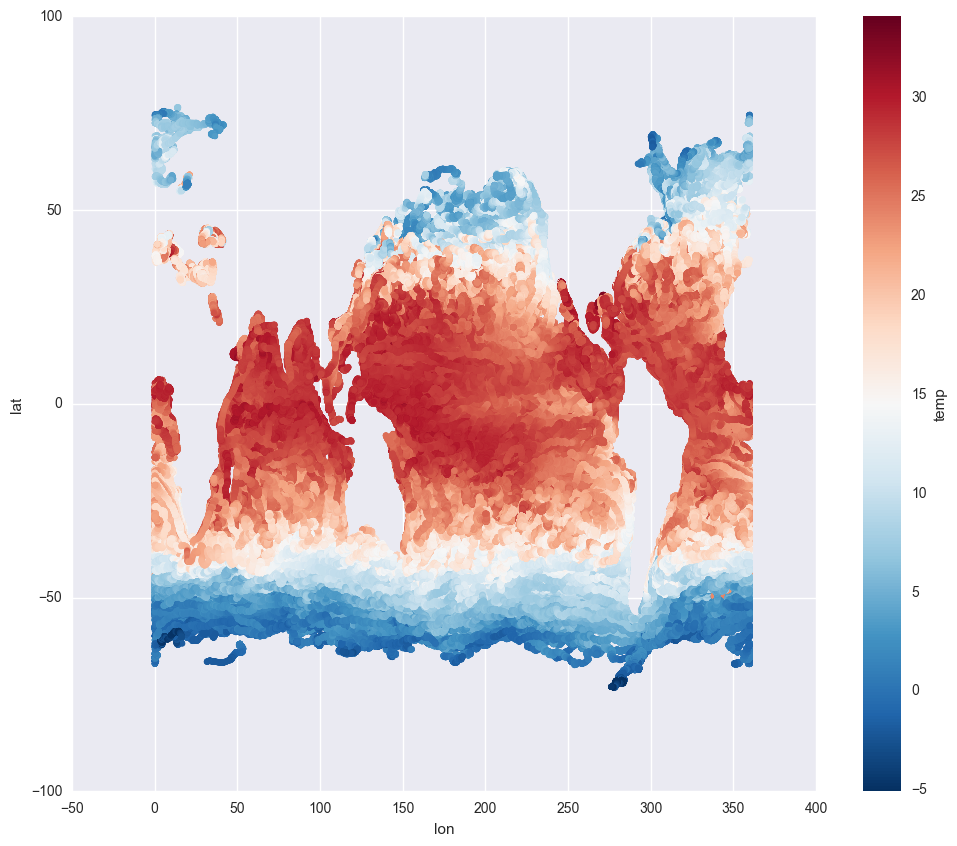

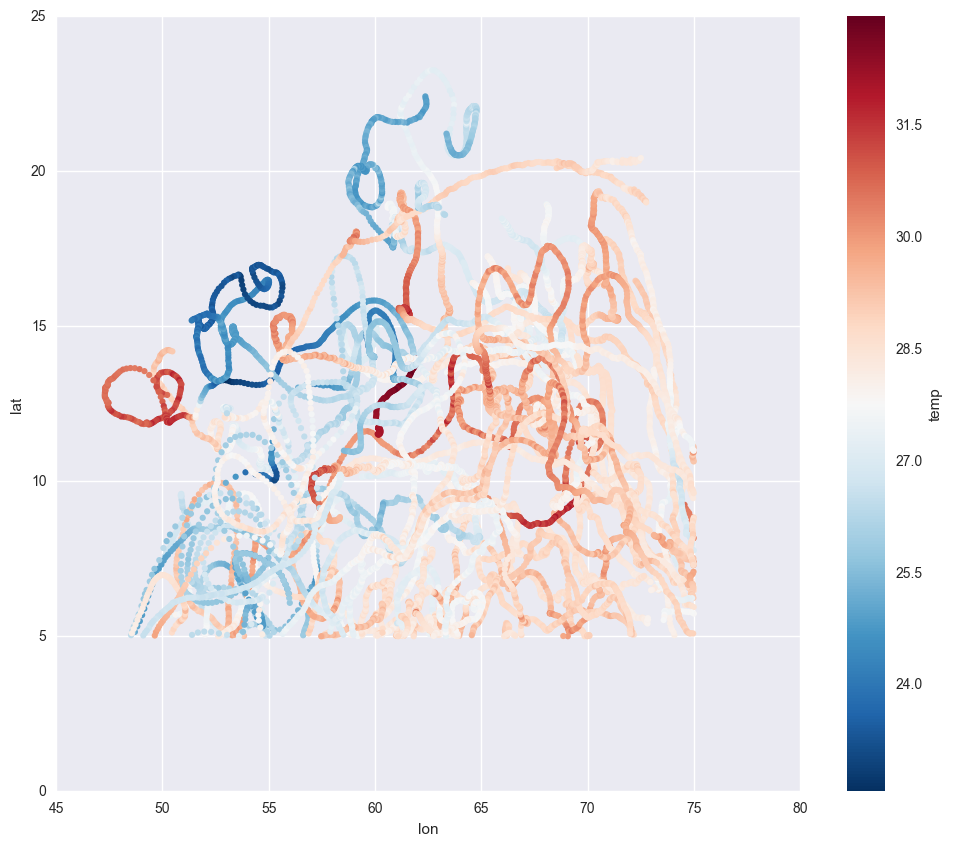

In [48]:
# visualization for the global and arabian sea region

# visualize the float around global region
fig, ax  = plt.subplots(figsize=(12,10))
dfvv.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floats.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [49]:
# pands dataframe cannot do the resamplingn properly
# cause we are really indexing on ['time','id'], pandas.dataframe.resample cannot do this
# TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'
print()

In [50]:
# dump the surface floater data from pandas.dataframe to xarray.dataset
floatsDS = xr.Dataset.from_dataframe(floats.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
floatsDS

<xarray.Dataset>
Dimensions:  (id: 60, time: 5705)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-04T06:00:00 ...
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
Data variables:
    lat      (time, id) float64 nan 16.3 14.03 16.4 14.04 nan 20.11 nan ...
    lon      (time, id) float64 nan 66.23 69.48 64.58 69.51 nan 68.55 nan ...
    temp     (time, id) float64 nan nan nan 28.0 28.53 nan 28.93 nan 27.81 ...
    ve       (time, id) float64 nan 8.68 5.978 6.286 4.844 nan 32.9 nan ...
    vn       (time, id) float64 nan -13.18 -18.05 -7.791 -17.47 nan 15.81 ...
    spd      (time, id) float64 nan 15.78 19.02 10.01 18.13 nan 36.51 nan ...
    var_lat  (time, id) float64 nan 0.0002661 5.01e-05 5.018e-05 5.024e-05 ...
    var_lon  (time, id) float64 nan 0.0006854 8.851e-05 9.018e-05 8.968e-05 ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.003733 0.0667 nan 0.001683 ...

In [51]:
# resample on the xarray.dataset onto two-day frequency
floatsDS_2D =floatsDS.resample('2D', dim='time')
floatsDS_2D

<xarray.Dataset>
Dimensions:  (id: 60, time: 973)
Coordinates:
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
  * time     (time) datetime64[ns] 2002-07-04 2002-07-06 2002-07-08 ...
Data variables:
    lon      (time, id) float64 nan 66.33 69.55 64.68 69.58 nan 68.74 nan ...
    ve       (time, id) float64 nan 13.06 8.505 12.17 8.686 nan 26.96 nan ...
    vn       (time, id) float64 nan -8.651 -20.75 -7.287 -20.2 nan 7.892 nan ...
    temp     (time, id) float64 nan nan nan 27.95 28.55 nan 29.01 nan 27.7 ...
    spd      (time, id) float64 nan 15.92 22.6 14.58 22.25 nan 28.45 nan ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.003688 0.07467 nan ...
    var_lon  (time, id) float64 nan 0.002281 9.329e-05 0.0001497 9.757e-05 ...
    lat      (time, id) float64 nan 16.23 13.89 16.35 13.9 nan 20.17 nan ...
    var_lat  (time, id) float64 nan 0.0007236 5.197e-05 7.609e-05 5.339e-05 ...

In [52]:
# transfer it back to pandas.dataframe for plotting
floatsDF_2D = floatsDS_2D.to_dataframe()
floatsDF_2D

lon  ve  vn  temp  spd  var_tmp  var_lon  lat  var_lat
id      time                                                              
7574    2002-07-04  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-07-06  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-07-08  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-07-10  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-07-12  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-07-14  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-07-16  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-07-18  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-07-20  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-07-22  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-07-24  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-07-26  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-07-28  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-07-30  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-01  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-03  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-05  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-07  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-09  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-11  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-13  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-15  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-17  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-19  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-21  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-23  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-25  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-27  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-29  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2002-08-31  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
...                 ...  ..  ..   ...  ...      ...      ...  ...      ...
2444350 2007-09-02  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-04  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-06  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-08  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-10  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-12  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-14  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-16  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-18  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-20  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-22  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-24  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-26  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-28  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-09-30  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-10-02  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-10-04  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-10-06  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-10-08  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-10-10  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN      NaN
        2007-10-12  NaN NaN NaN   NaN  NaN   

In [53]:
floatsDF_2D = floatsDF_2D.reset_index()
floatsDF_2D

id       time  lon  ve  vn  temp  spd  var_tmp  var_lon  lat  \
0         7574 2002-07-04  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
1         7574 2002-07-06  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
2         7574 2002-07-08  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
3         7574 2002-07-10  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
4         7574 2002-07-12  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
5         7574 2002-07-14  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
6         7574 2002-07-16  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
7         7574 2002-07-18  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
8         7574 2002-07-20  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
9         7574 2002-07-22  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
10        7574 2002-07-24  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
11        7574 2002-07-26  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
12        7574 2002-07-28  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
13        7574 2002-07-30  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
14        7574 2002-08-01  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
15        7574 2002-08-03  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
16        7574 2002-08-05  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
17        7574 2002-08-07  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
18        7574 2002-08-09  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
19        7574 2002-08-11  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
20        7574 2002-08-13  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
21        7574 2002-08-15  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
22        7574 2002-08-17  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
23        7574 2002-08-19  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
24        7574 2002-08-21  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
25        7574 2002-08-23  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
26        7574 2002-08-25  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
27        7574 2002-08-27  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
28        7574 2002-08-29  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
29        7574 2002-08-31  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
...        ...        ...  ...  ..  ..   ...  ...      ...      ...  ...   
58350  2444350 2007-09-02  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58351  2444350 2007-09-04  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58352  2444350 2007-09-06  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58353  2444350 2007-09-08  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58354  2444350 2007-09-10  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58355  2444350 2007-09-12  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58356  2444350 2007-09-14  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58357  2444350 2007-09-16  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58358  2444350 2007-09-18  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58359  2444350 2007-09-20  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58360  2444350 2007-09-22  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58361  2444350 2007-09-24  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58362  2444350 2007-09-26  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58363  2444350 2007-09-28  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58364  2444350 2007-09-30  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58365  2444350 2007-10-02  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58366  2444350 2007-10-04  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58367  2444350 2007-10-06  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58368  2444350 2007-10-08  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58369  2444350 2007-10-10  NaN NaN NaN   NaN  NaN      NaN      NaN  NaN   
58370  2444350 2007-10-12  NaN NaN NaN   NaN  NaN      NaN  

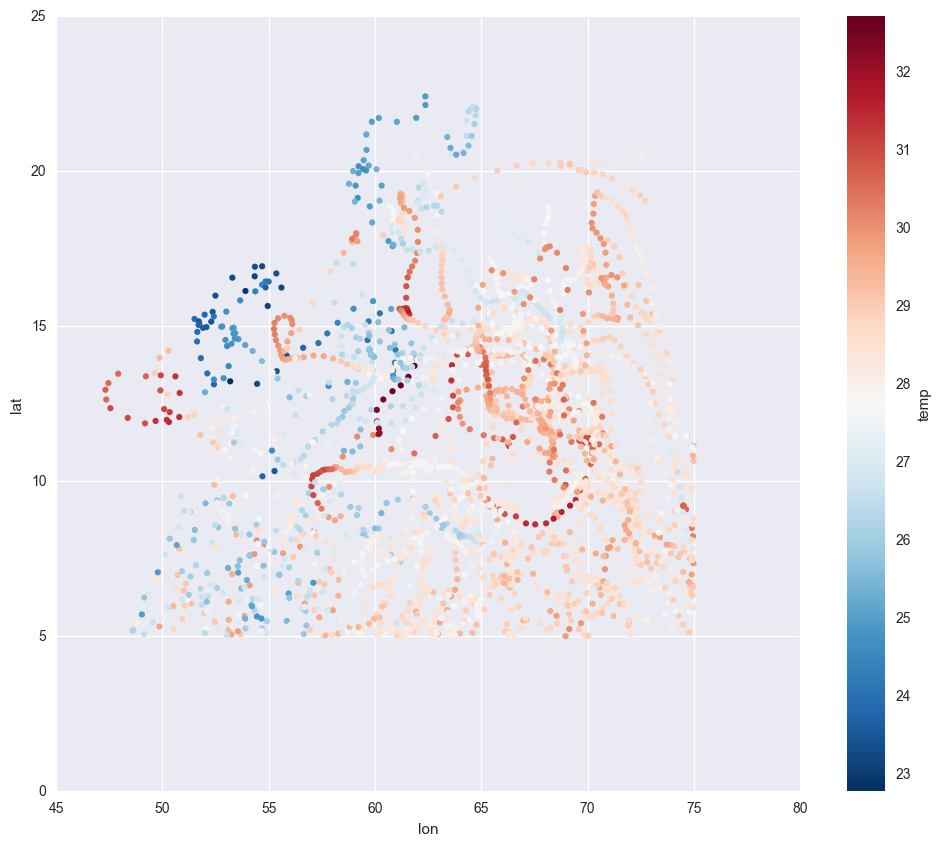

In [54]:
# visualize the 2D-floats around arabian region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDF_2D.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [55]:
# get the value for the chllorophy for each data entry
floats_timeorder = floatsDF_2D.sort_values(['time','id'],ascending=True)

In [56]:
floats_timeorder  # check whether it is time ordered!!

id       time        lon         ve         vn       temp  \
0         7574 2002-07-04        NaN        NaN        NaN        NaN   
973      10206 2002-07-04  66.330375  13.064500  -8.650875        NaN   
1946     10208 2002-07-04  69.552375   8.505125 -20.755000        NaN   
2919     11089 2002-07-04  64.683750  12.168000  -7.286875  27.954125   
3892     15703 2002-07-04  69.583125   8.685875 -20.195125  28.552250   
4865     15707 2002-07-04        NaN        NaN        NaN        NaN   
5838     27069 2002-07-04  68.737500  26.958750   7.891750  29.012000   
6811     27139 2002-07-04        NaN        NaN        NaN        NaN   
7784     28842 2002-07-04  60.694625  10.499125  -0.333875  27.701750   
8757     34159 2002-07-04  58.914250  27.354250   4.591750        NaN   
9730     34210 2002-07-04  56.925000  -9.666750 -13.510125  26.694875   
10703    34211 2002-07-04  67.929125  20.618125 -12.301625  28.278000   
11676    34212 2002-07-04  64.750250  14.641875  13.108750  28.470750   
12649    34223 2002-07-04        NaN        NaN        NaN        NaN   
13622    34310 2002-07-04        NaN        NaN        NaN        NaN   
14595    34311 2002-07-04        NaN        NaN        NaN        NaN   
15568    34312 2002-07-04        NaN        NaN        NaN        NaN   
16541    34314 2002-07-04        NaN        NaN        NaN        NaN   
17514    34315 2002-07-04        NaN        NaN        NaN        NaN   
18487    34374 2002-07-04        NaN        NaN        NaN        NaN   
19460    34708 2002-07-04  59.691500  47.792000   2.521375  27.185500   
20433    34709 2002-07-04        NaN        NaN        NaN        NaN   
21406    34710 2002-07-04  49.905250 -34.754625  24.402875  30.910625   
22379    34714 2002-07-04  63.649625  38.417625  12.527125  27.686625   
23352    34716 2002-07-04  65.384500  38.942875  -0.596250  28.801750   
24325    34718 2002-07-04  72.396375  21.462750 -24.061500  29.153625   
25298    34719 2002-07-04  70.946250  19.908500  -7.665125  28.922500   
26271    34720 2002-07-04  69.187000  10.269000 -36.005250  28.644250   
27244    34721 2002-07-04  65.375250   8.379375  -9.067750  27.943750   
28217    34722 2002-07-04  70.472250  10.214125  -3.672500  28.734000   
...        ...        ...        ...        ...        ...        ...   
30162    34723 2007-10-30        NaN        NaN        NaN        NaN   
31135    36530 2007-10-30        NaN        NaN        NaN        NaN   
32108    36537 2007-10-30        NaN        NaN        NaN        NaN   
33081    43598 2007-10-30        NaN        NaN        NaN        NaN   
34054    43740 2007-10-30        NaN        NaN        NaN        NaN   
35027    43743 2007-10-30        NaN        NaN        NaN        NaN   
36000    43744 2007-10-30        NaN        NaN        NaN        NaN   
36973    43746 2007-10-30        NaN        NaN        NaN        NaN   
37946    43748 2007-10-30        NaN        NaN        NaN        NaN   
38919    43995 2007-10-30        NaN        NaN        NaN        NaN   
39892    46470 2007-10-30        NaN        NaN        NaN        NaN   
40865    46471 2007-10-30        NaN        NaN        NaN        NaN   
41838    46472 2007-10-30        NaN        NaN        NaN        NaN   
42811    53352 2007-10-30        NaN        NaN        NaN        NaN   
43784    53358 2007-10-30        NaN        NaN        NaN        NaN   
44757    53363 2007-10-30        NaN        NaN        NaN        NaN   
45730    53364 2007-10-30        NaN        NaN        NaN        NaN   
46703    53365 2007-10-30        NaN        NaN        NaN        NaN   
47676    53366 2007-10-30        NaN        NaN        NaN        NaN   
48649    53367 2007-10-30        NaN        NaN        NaN        NaN   
49622    53404 2007-10-30  53.022400  -7.558000 -11.945500  26.730200   
50595    54371 2007-10-30        NaN        NaN        NaN        NaN   
51568    57939 2007-10-30        NaN        NaN        NaN        NaN 

In [57]:
# a. loops through entries in the float
# b. add the chl data to the floater data
# c. then take the difference for the lagrange rate of change

In [58]:
# a little test for the api in loops for the dataframe   
# check df.itertuples? it is faster and preserves the data format
'''
chl_ocx=[]
for row in floats_timeorder.itertuples():
    #print(row)
    #print('row.time = %s, row.id=%d, row.lon=%4.3f, row.lat=%4.3f' % (row.time,row.id,row.lon,row.lat)  )
    tmp=ds_2day.chl_ocx.sel_points(time=[row.time],lon=[row.lon], lat=[row.lat], method='nearest') # interpolation
    chl_ocx.append(tmp)
floats_timeorder['chl_ocx'] = pd.Series(chl_ocx, index=floats_timeorder.index)
chl_ocx[0].to_series
'''

"\nchl_ocx=[]\nfor row in floats_timeorder.itertuples():\n    #print(row)\n    #print('row.time = %s, row.id=%d, row.lon=%4.3f, row.lat=%4.3f' % (row.time,row.id,row.lon,row.lat)  )\n    tmp=ds_2day.chl_ocx.sel_points(time=[row.time],lon=[row.lon], lat=[row.lat], method='nearest') # interpolation\n    chl_ocx.append(tmp)\nfloats_timeorder['chl_ocx'] = pd.Series(chl_ocx, index=floats_timeorder.index)\nchl_ocx[0].to_series\n"

In [59]:
# this one line avoid the list above
tmp = ds_2day.chlor_a.sel_points(time=list(floats_timeorder.time),lon=list(floats_timeorder.lon), lat=list(floats_timeorder.lat), method='nearest')
print('the count of nan vaues in tmp is',tmp.to_series().isnull().sum())

# tmp.to_series() to transfer it from xarray dataset to series
floats_timeorder['chlor_a'] = pd.Series(np.array(tmp.to_series()), index=floats_timeorder.index)
print("after editing the dataframe the non values in 'chlor_a' is",floats_timeorder.chlor_a.isnull().sum() )

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/indexes/base.py:2352: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/indexes/base.py:2352: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


the count of nan vaues in tmp is 57795
after editing the dataframe the non values in 'chlor_a' is 57795


In [60]:
# take a look at the data
floats_timeorder

id       time        lon         ve         vn       temp  \
0         7574 2002-07-04        NaN        NaN        NaN        NaN   
973      10206 2002-07-04  66.330375  13.064500  -8.650875        NaN   
1946     10208 2002-07-04  69.552375   8.505125 -20.755000        NaN   
2919     11089 2002-07-04  64.683750  12.168000  -7.286875  27.954125   
3892     15703 2002-07-04  69.583125   8.685875 -20.195125  28.552250   
4865     15707 2002-07-04        NaN        NaN        NaN        NaN   
5838     27069 2002-07-04  68.737500  26.958750   7.891750  29.012000   
6811     27139 2002-07-04        NaN        NaN        NaN        NaN   
7784     28842 2002-07-04  60.694625  10.499125  -0.333875  27.701750   
8757     34159 2002-07-04  58.914250  27.354250   4.591750        NaN   
9730     34210 2002-07-04  56.925000  -9.666750 -13.510125  26.694875   
10703    34211 2002-07-04  67.929125  20.618125 -12.301625  28.278000   
11676    34212 2002-07-04  64.750250  14.641875  13.108750  28.470750   
12649    34223 2002-07-04        NaN        NaN        NaN        NaN   
13622    34310 2002-07-04        NaN        NaN        NaN        NaN   
14595    34311 2002-07-04        NaN        NaN        NaN        NaN   
15568    34312 2002-07-04        NaN        NaN        NaN        NaN   
16541    34314 2002-07-04        NaN        NaN        NaN        NaN   
17514    34315 2002-07-04        NaN        NaN        NaN        NaN   
18487    34374 2002-07-04        NaN        NaN        NaN        NaN   
19460    34708 2002-07-04  59.691500  47.792000   2.521375  27.185500   
20433    34709 2002-07-04        NaN        NaN        NaN        NaN   
21406    34710 2002-07-04  49.905250 -34.754625  24.402875  30.910625   
22379    34714 2002-07-04  63.649625  38.417625  12.527125  27.686625   
23352    34716 2002-07-04  65.384500  38.942875  -0.596250  28.801750   
24325    34718 2002-07-04  72.396375  21.462750 -24.061500  29.153625   
25298    34719 2002-07-04  70.946250  19.908500  -7.665125  28.922500   
26271    34720 2002-07-04  69.187000  10.269000 -36.005250  28.644250   
27244    34721 2002-07-04  65.375250   8.379375  -9.067750  27.943750   
28217    34722 2002-07-04  70.472250  10.214125  -3.672500  28.734000   
...        ...        ...        ...        ...        ...        ...   
30162    34723 2007-10-30        NaN        NaN        NaN        NaN   
31135    36530 2007-10-30        NaN        NaN        NaN        NaN   
32108    36537 2007-10-30        NaN        NaN        NaN        NaN   
33081    43598 2007-10-30        NaN        NaN        NaN        NaN   
34054    43740 2007-10-30        NaN        NaN        NaN        NaN   
35027    43743 2007-10-30        NaN        NaN        NaN        NaN   
36000    43744 2007-10-30        NaN        NaN        NaN        NaN   
36973    43746 2007-10-30        NaN        NaN        NaN        NaN   
37946    43748 2007-10-30        NaN        NaN        NaN        NaN   
38919    43995 2007-10-30        NaN        NaN        NaN        NaN   
39892    46470 2007-10-30        NaN        NaN        NaN        NaN   
40865    46471 2007-10-30        NaN        NaN        NaN        NaN   
41838    46472 2007-10-30        NaN        NaN        NaN        NaN   
42811    53352 2007-10-30        NaN        NaN        NaN        NaN   
43784    53358 2007-10-30        NaN        NaN        NaN        NaN   
44757    53363 2007-10-30        NaN        NaN        NaN        NaN   
45730    53364 2007-10-30        NaN        NaN        NaN        NaN   
46703    53365 2007-10-30        NaN        NaN        NaN        NaN   
47676    53366 2007-10-30        NaN        NaN        NaN        NaN   
48649    53367 2007-10-30        NaN        NaN        NaN        NaN   
49622    53404 2007-10-30  53.022400  -7.558000 -11.945500  26.730200   
50595    54371 2007-10-30        NaN        NaN        NaN        NaN   
51568    57939 2007-10-30        NaN        NaN        NaN        NaN 

In [61]:
######
# test for how to add a column to the dataframe
######
pd.Series(np.array(tmp.to_series())[:10], index = [3,4,5,6,7,8,9,10,15,22])
# if not make the first argument as pure np.array, then the index will based on the first entry!!!
#pd.Series(tmp.to_series()[:10], index = [3,4,5,6,7,8,9,10,15,22]) # does use this function

3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
15   NaN
22   NaN
dtype: float64

# ++++++++++++++++++++++++++++++++++++++++++++++
# All GDP Floats
# Load the float data
# Map a (time, lon, lat) to a value on the cholorphlly value

In [62]:
# in the following we deal with the data from the gdp float
from buyodata import buoydata
import os

In [63]:
# a list of files
fnamesAll = ['./gdp_float/buoydata_1_5000.dat','./gdp_float/buoydata_5001_10000.dat','./gdp_float/buoydata_10001_15000.dat','./gdp_float/buoydata_15001_jun16.dat']
#fnames = ['./gdp_float/buoydata_1_5000.dat']

In [64]:
# read them and cancatenate them into one DataFrame
dfAll = pd.concat([buoydata.read_buoy_data(f) for f in fnamesAll])  # around 4~5 minutes

#mask = df.time>='2002-07-04' # we only have data after this data for chlor_a
dfvvAll = dfAll[dfAll.time>='2002-07-04']

sum(dfvvAll.time<'2002-07-04') # recheck whether the time is 



0

In [65]:
print()

In [66]:
# process the data so that the longitude are all >0
print('before processing, the minimum longitude is%f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(), dfvvAll.lon.max()))
mask = dfvvAll.lon<0
dfvvAll.lon[mask] = dfvvAll.loc[mask].lon + 360
print('after processing, the minimum longitude is %f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(),dfvvAll.lon.max()) )

dfvvAll.describe()

before processing, the minimum longitude is0.0000004.3 and maximum is 360.0000004.3


/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/core/generic.py:4695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

after processing, the minimum longitude is 0.0000004.3 and maximum is 360.0000004.3


id           lat           lon          temp            ve  \
count  2.147732e+07  2.131997e+07  2.131997e+07  1.986179e+07  2.129142e+07   
mean   1.765662e+06 -2.263128e+00  2.124412e+02  1.986121e+01  2.454172e-01   
std    9.452835e+06  3.401115e+01  9.746941e+01  8.339498e+00  2.525050e+01   
min    2.578000e+03 -7.764700e+01  0.000000e+00 -1.685000e+01 -2.916220e+02   
25%    4.897500e+04 -3.186000e+01  1.490720e+02  1.437300e+01 -1.411400e+01   
50%    7.141300e+04 -4.920000e+00  2.153940e+02  2.214400e+01 -5.560000e-01   
75%    1.094330e+05  2.756000e+01  3.064370e+02  2.688900e+01  1.356100e+01   
max    6.399288e+07  8.989900e+01  3.600000e+02  4.595000e+01  4.417070e+02   

                 vn           spd       var_lat       var_lon       var_tmp  
count  2.129142e+07  2.129142e+07  2.147732e+07  2.147732e+07  2.147732e+07  
mean   4.708192e-01  2.613427e+01  7.326258e+00  7.326555e+00  7.522298e+01  
std    2.052160e+01  1.939087e+01  8.527853e+01  8.527851e+01  2.637454e+02  
min   -2.601400e+02  0.000000e+00  5.268300e-07 -3.941600e-02  1.001300e-03  
25%   -1.044700e+01  1.290300e+01  4.366500e-06  7.512600e-06  1.435700e-03  
50%    1.970000e-01  2.176700e+01  8.833600e-06  1.495800e-05  1.691700e-03  
75%    1.109300e+01  3.405900e+01  1.833300e-05  3.627900e-05  2.294200e-03  
max    2.783220e+02  4.421750e+02  1.000000e+03  1.000000e+03  1.000000e+03

dfvvAll.shape is (21477317, 11), floatsAll.shape is (111894, 11)


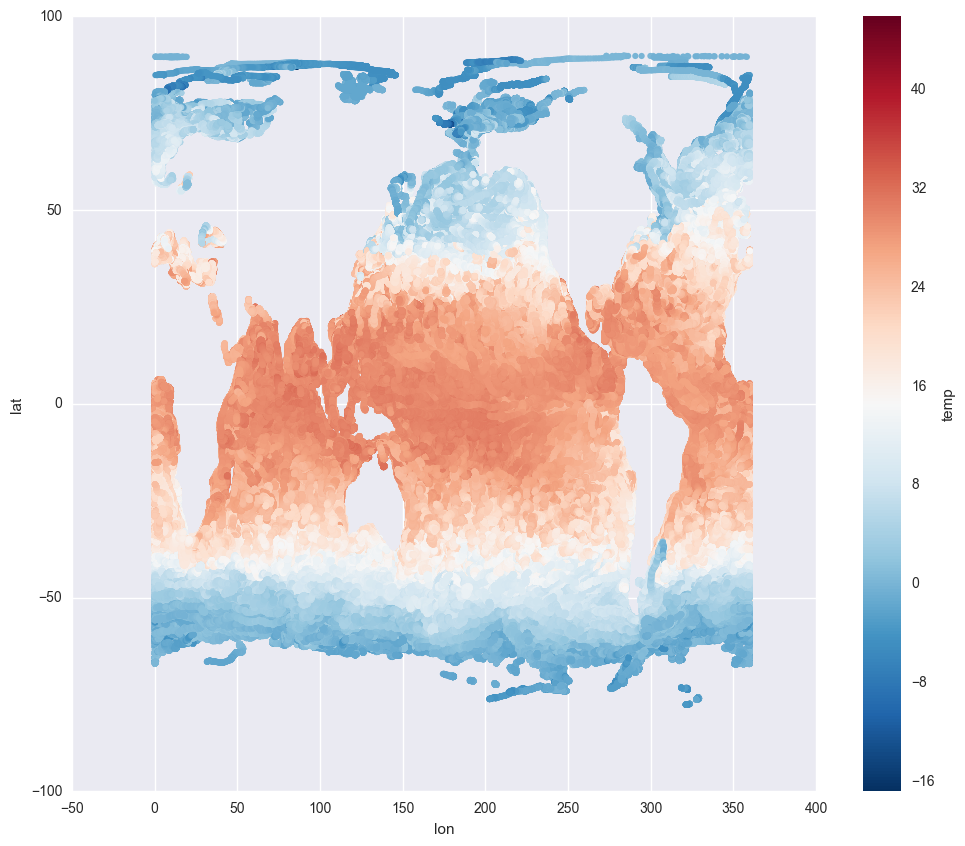

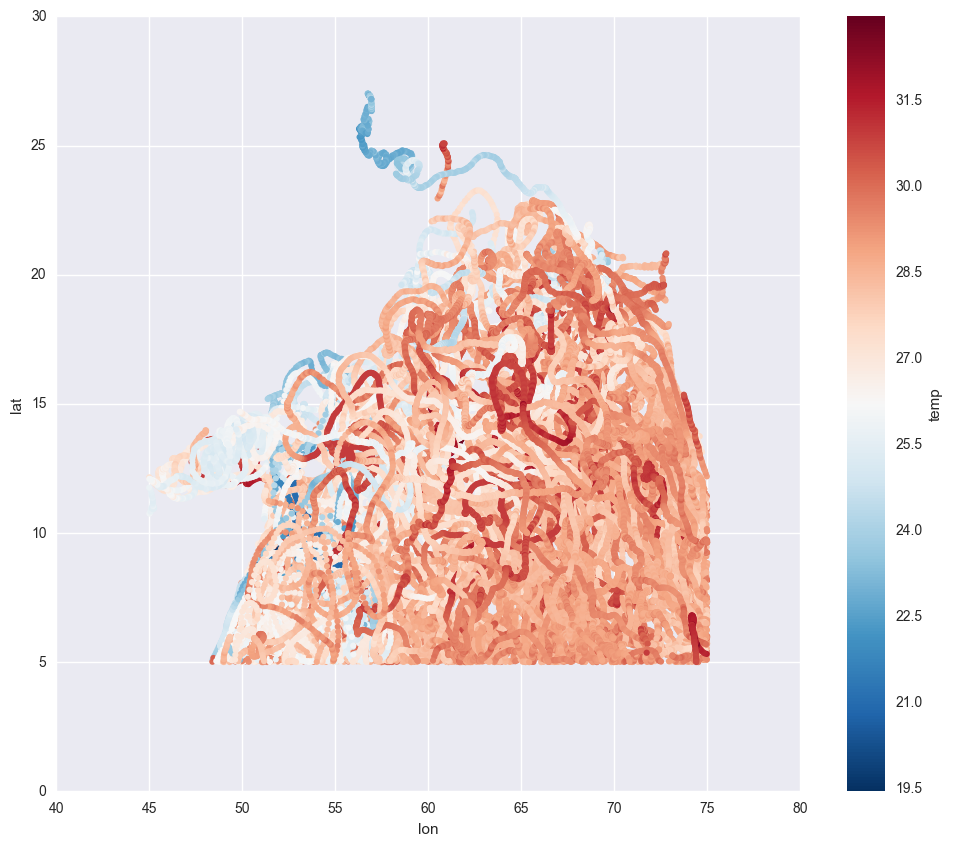

In [67]:
# Select only the arabian sea region
arabian_sea = (dfvvAll.lon > 45) & (dfvvAll.lon< 75) & (dfvvAll.lat> 5) & (dfvvAll.lat <28)
# arabian_sea = {'lon': slice(45,75), 'lat': slice(5,28)} # later use this longitude and latitude
floatsAll = dfvvAll.loc[arabian_sea]   # directly use mask
print('dfvvAll.shape is %s, floatsAll.shape is %s' % (dfvvAll.shape, floatsAll.shape) )


# visualize the float around global region
fig, ax  = plt.subplots(figsize=(12,10))
dfvvAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [68]:
# pands dataframe cannot do the resamplingn properly
# cause we are really indexing on ['time','id'], pandas.dataframe.resample cannot do this
# TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'
print()

In [69]:
# dump the surface floater data from pandas.dataframe to xarray.dataset
floatsDSAll = xr.Dataset.from_dataframe(floatsAll.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
floatsDSAll

<xarray.Dataset>
Dimensions:  (id: 259, time: 17499)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-04T06:00:00 ...
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
Data variables:
    lat      (time, id) float64 nan 16.3 14.03 16.4 14.04 nan 20.11 nan ...
    lon      (time, id) float64 nan 66.23 69.48 64.58 69.51 nan 68.55 nan ...
    temp     (time, id) float64 nan nan nan 28.0 28.53 nan 28.93 nan 27.81 ...
    ve       (time, id) float64 nan 8.68 5.978 6.286 4.844 nan 32.9 nan ...
    vn       (time, id) float64 nan -13.18 -18.05 -7.791 -17.47 nan 15.81 ...
    spd      (time, id) float64 nan 15.78 19.02 10.01 18.13 nan 36.51 nan ...
    var_lat  (time, id) float64 nan 0.0002661 5.01e-05 5.018e-05 5.024e-05 ...
    var_lon  (time, id) float64 nan 0.0006854 8.851e-05 9.018e-05 8.968e-05 ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.003733 0.0667 nan 0.001683 ...

In [70]:
# resample on the xarray.dataset onto two-day frequency
floatsDSAll_2D =floatsDSAll.resample('2D', dim='time')
floatsDSAll_2D

<xarray.Dataset>
Dimensions:  (id: 259, time: 2556)
Coordinates:
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
  * time     (time) datetime64[ns] 2002-07-04 2002-07-06 2002-07-08 ...
Data variables:
    lon      (time, id) float64 nan 66.33 69.55 64.68 69.58 nan 68.74 nan ...
    ve       (time, id) float64 nan 13.06 8.505 12.17 8.686 nan 26.96 nan ...
    vn       (time, id) float64 nan -8.651 -20.75 -7.287 -20.2 nan 7.892 nan ...
    temp     (time, id) float64 nan nan nan 27.95 28.55 nan 29.01 nan 27.7 ...
    spd      (time, id) float64 nan 15.92 22.6 14.58 22.25 nan 28.45 nan ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.003688 0.07467 nan ...
    var_lon  (time, id) float64 nan 0.002281 9.329e-05 0.0001497 9.757e-05 ...
    lat      (time, id) float64 nan 16.23 13.89 16.35 13.9 nan 20.17 nan ...
    var_lat  (time, id) float64 nan 0.0007236 5.197e-05 7.609e-05 5.339e-05 ...

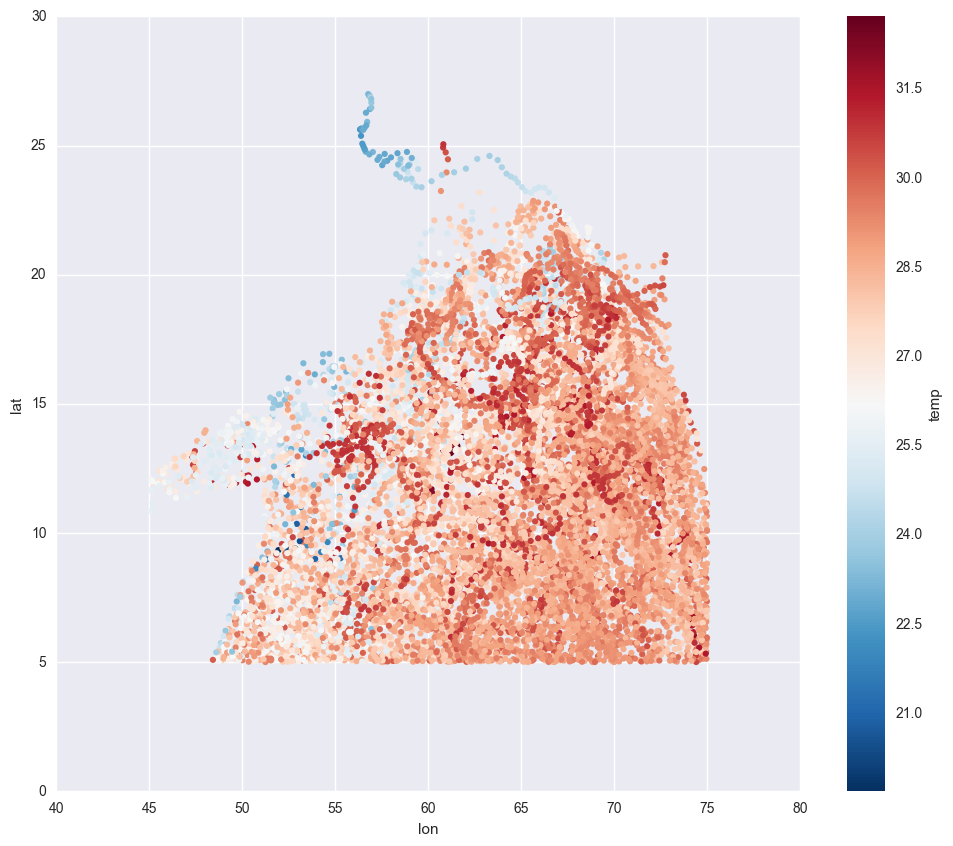

In [71]:
# transfer it back to pandas.dataframe for plotting
floatsDFAll_2D = floatsDSAll_2D.to_dataframe()
floatsDFAll_2D
floatsDFAll_2D = floatsDFAll_2D.reset_index()
floatsDFAll_2D
# visualize the 2D-floats around arabian region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_2D.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [72]:
# get the value for the chllorophy for each data entry
floatsDFAll_2Dtimeorder = floatsDFAll_2D.sort_values(['time','id'],ascending=True)
floatsDFAll_2Dtimeorder # check whether it is time ordered!!
# should we drop nan to speed up??

id       time        lon         ve         vn       temp  \
0           7574 2002-07-04        NaN        NaN        NaN        NaN   
2556       10206 2002-07-04  66.330375  13.064500  -8.650875        NaN   
5112       10208 2002-07-04  69.552375   8.505125 -20.755000        NaN   
7668       11089 2002-07-04  64.683750  12.168000  -7.286875  27.954125   
10224      15703 2002-07-04  69.583125   8.685875 -20.195125  28.552250   
12780      15707 2002-07-04        NaN        NaN        NaN        NaN   
15336      27069 2002-07-04  68.737500  26.958750   7.891750  29.012000   
17892      27139 2002-07-04        NaN        NaN        NaN        NaN   
20448      28842 2002-07-04  60.694625  10.499125  -0.333875  27.701750   
23004      34159 2002-07-04  58.914250  27.354250   4.591750        NaN   
25560      34173 2002-07-04        NaN        NaN        NaN        NaN   
28116      34210 2002-07-04  56.925000  -9.666750 -13.510125  26.694875   
30672      34211 2002-07-04  67.929125  20.618125 -12.301625  28.278000   
33228      34212 2002-07-04  64.750250  14.641875  13.108750  28.470750   
35784      34223 2002-07-04        NaN        NaN        NaN        NaN   
38340      34310 2002-07-04        NaN        NaN        NaN        NaN   
40896      34311 2002-07-04        NaN        NaN        NaN        NaN   
43452      34312 2002-07-04        NaN        NaN        NaN        NaN   
46008      34314 2002-07-04        NaN        NaN        NaN        NaN   
48564      34315 2002-07-04        NaN        NaN        NaN        NaN   
51120      34374 2002-07-04        NaN        NaN        NaN        NaN   
53676      34708 2002-07-04  59.691500  47.792000   2.521375  27.185500   
56232      34709 2002-07-04        NaN        NaN        NaN        NaN   
58788      34710 2002-07-04  49.905250 -34.754625  24.402875  30.910625   
61344      34714 2002-07-04  63.649625  38.417625  12.527125  27.686625   
63900      34716 2002-07-04  65.384500  38.942875  -0.596250  28.801750   
66456      34718 2002-07-04  72.396375  21.462750 -24.061500  29.153625   
69012      34719 2002-07-04  70.946250  19.908500  -7.665125  28.922500   
71568      34720 2002-07-04  69.187000  10.269000 -36.005250  28.644250   
74124      34721 2002-07-04  65.375250   8.379375  -9.067750  27.943750   
...          ...        ...        ...        ...        ...        ...   
587879   3098682 2016-06-30        NaN        NaN        NaN        NaN   
590435  60073460 2016-06-30        NaN        NaN        NaN        NaN   
592991  60074440 2016-06-30        NaN        NaN        NaN        NaN   
595547  60077450 2016-06-30        NaN        NaN        NaN        NaN   
598103  60150420 2016-06-30        NaN        NaN        NaN        NaN   
600659  60454500 2016-06-30        NaN        NaN        NaN        NaN   
603215  60656200 2016-06-30        NaN        NaN        NaN        NaN   
605771  60657200 2016-06-30        NaN        NaN        NaN        NaN   
608327  60658190 2016-06-30        NaN        NaN        NaN        NaN   
610883  60659110 2016-06-30        NaN        NaN        NaN        NaN   
613439  60659120 2016-06-30        NaN        NaN        NaN        NaN   
615995  60659190 2016-06-30        NaN        NaN        NaN        NaN   
618551  60659200 2016-06-30        NaN        NaN        NaN        NaN   
621107  60940960 2016-06-30        NaN        NaN        NaN        NaN   
623663  60940970 2016-06-30        NaN        NaN        NaN        NaN   
626219  60941960 2016-06-30        NaN        NaN        NaN        NaN   
628775  60941970 2016-06-30        NaN        NaN        NaN        NaN   
631331  60942960 2016-06-30        NaN        NaN        NaN        NaN   
633887  60942970 2016-06-30        NaN        NaN        NaN        NaN   
636443  60943960 2016-06-30        NaN        NaN        NaN        NaN   
638999  60943970 2016-06-30        NaN        NaN        NaN        NaN   
641555  60944960 2016-06-30        NaN 

In [73]:
floatsDFAll_2Dtimeorder.lon.dropna().shape  # the longitude data has lots of values (14340,)

(14340,)

In [74]:
# this one line avoid the list above
# it took a really long time for 2D interpolation, it takes an hour
tmpAll = ds_2day.chlor_a.sel_points(time=list(floatsDFAll_2Dtimeorder.time),lon=list(floatsDFAll_2Dtimeorder.lon), lat=list(floatsDFAll_2Dtimeorder.lat), method='nearest')
print('the count of nan vaues in tmpAll is',tmpAll.to_series().isnull().sum())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/indexes/base.py:2352: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/indexes/base.py:2352: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


the count of nan vaues in tmpAll is 659258


In [75]:
#print(tmpAll.dropna().shape)
tmpAll.to_series().dropna().shape  # (2746,) good values

(2746,)

In [76]:
print()

after editing the dataframe the nan values in 'chlor_a' is 659258


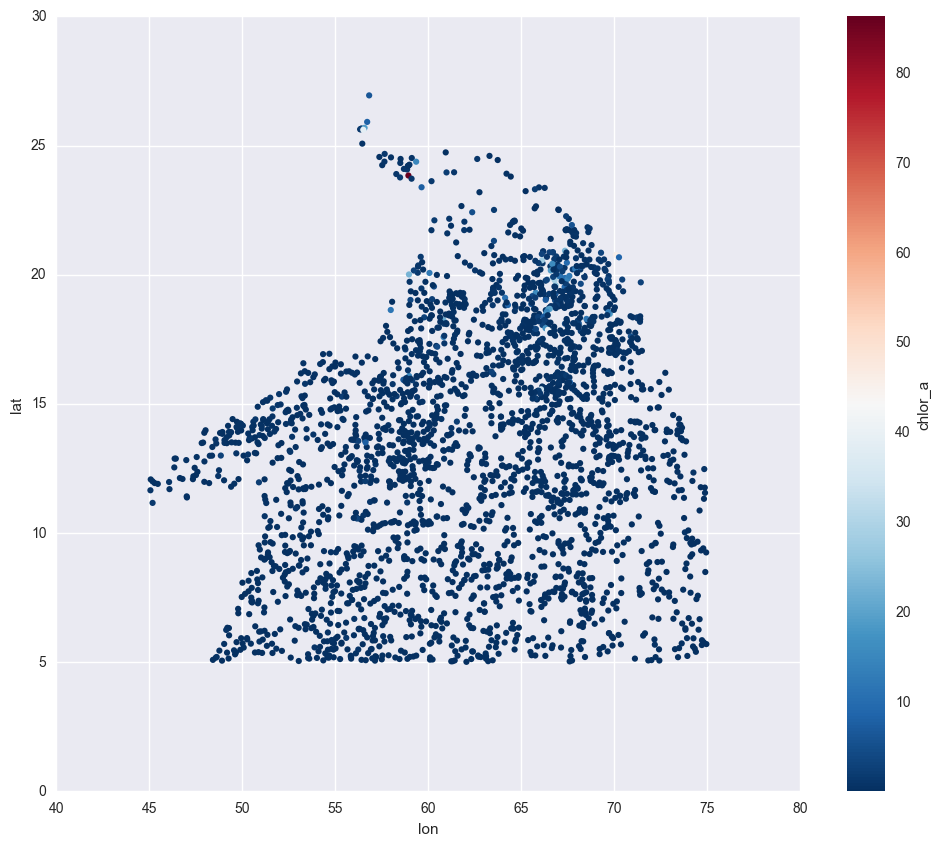

In [77]:
# tmp.to_series() to transfer it from xarray dataset to series
floatsDFAll_2Dtimeorder['chlor_a'] = pd.Series(np.array(tmpAll.to_series()), index=floatsDFAll_2Dtimeorder.index)

print("after editing the dataframe the nan values in 'chlor_a' is",floatsDFAll_2Dtimeorder.chlor_a.isnull().sum() )  # they should be the same values as above

# take a look at the data
floatsDFAll_2Dtimeorder

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_2Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chlor_a', cmap='RdBu_r', edgecolor='none', ax=ax)

In [78]:
def scale(x):
    logged = np.log10(x)
    return logged

(2746,)

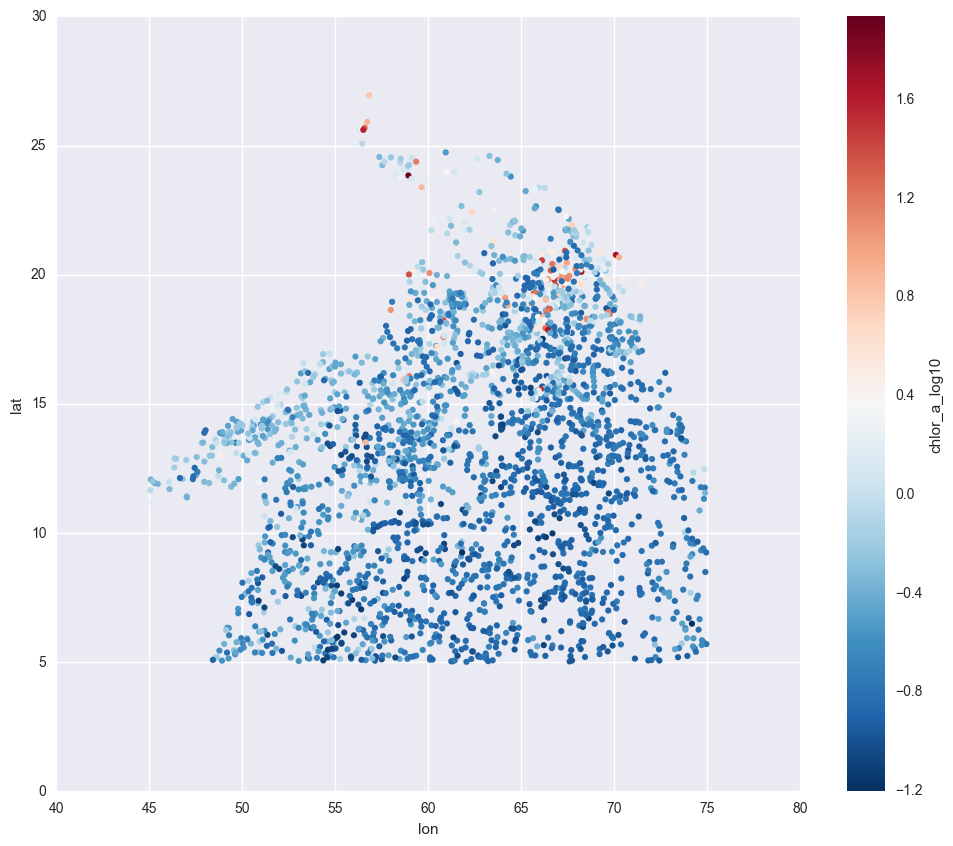

In [79]:
#print(floatsAll_timeorder['chlor_a'].apply(scale))
floatsDFAll_2Dtimeorder['chlor_a_log10'] = floatsDFAll_2Dtimeorder['chlor_a'].apply(scale)
floatsDFAll_2Dtimeorder
#print("after the transformation the nan values in 'chlor_a_log10' is", floatsAll_timeorder.chlor_a_log10.isnull().sum() )

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_2Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chlor_a_log10', cmap='RdBu_r', edgecolor='none', ax=ax)
floatsDFAll_2Dtimeorder.chlor_a.dropna().shape  # (2746,) 
# floatsDFAll_2Dtimeorder.chlor_a_log10.dropna().shape  # (2746,) 

In [80]:
# take the diff of the chlor_a, and this has to be done in xarray
# transfer the dataframe into xarry dataset again
# take the difference
floatsDFAll_2Dtimeorder

id       time        lon         ve         vn       temp  \
0           7574 2002-07-04        NaN        NaN        NaN        NaN   
2556       10206 2002-07-04  66.330375  13.064500  -8.650875        NaN   
5112       10208 2002-07-04  69.552375   8.505125 -20.755000        NaN   
7668       11089 2002-07-04  64.683750  12.168000  -7.286875  27.954125   
10224      15703 2002-07-04  69.583125   8.685875 -20.195125  28.552250   
12780      15707 2002-07-04        NaN        NaN        NaN        NaN   
15336      27069 2002-07-04  68.737500  26.958750   7.891750  29.012000   
17892      27139 2002-07-04        NaN        NaN        NaN        NaN   
20448      28842 2002-07-04  60.694625  10.499125  -0.333875  27.701750   
23004      34159 2002-07-04  58.914250  27.354250   4.591750        NaN   
25560      34173 2002-07-04        NaN        NaN        NaN        NaN   
28116      34210 2002-07-04  56.925000  -9.666750 -13.510125  26.694875   
30672      34211 2002-07-04  67.929125  20.618125 -12.301625  28.278000   
33228      34212 2002-07-04  64.750250  14.641875  13.108750  28.470750   
35784      34223 2002-07-04        NaN        NaN        NaN        NaN   
38340      34310 2002-07-04        NaN        NaN        NaN        NaN   
40896      34311 2002-07-04        NaN        NaN        NaN        NaN   
43452      34312 2002-07-04        NaN        NaN        NaN        NaN   
46008      34314 2002-07-04        NaN        NaN        NaN        NaN   
48564      34315 2002-07-04        NaN        NaN        NaN        NaN   
51120      34374 2002-07-04        NaN        NaN        NaN        NaN   
53676      34708 2002-07-04  59.691500  47.792000   2.521375  27.185500   
56232      34709 2002-07-04        NaN        NaN        NaN        NaN   
58788      34710 2002-07-04  49.905250 -34.754625  24.402875  30.910625   
61344      34714 2002-07-04  63.649625  38.417625  12.527125  27.686625   
63900      34716 2002-07-04  65.384500  38.942875  -0.596250  28.801750   
66456      34718 2002-07-04  72.396375  21.462750 -24.061500  29.153625   
69012      34719 2002-07-04  70.946250  19.908500  -7.665125  28.922500   
71568      34720 2002-07-04  69.187000  10.269000 -36.005250  28.644250   
74124      34721 2002-07-04  65.375250   8.379375  -9.067750  27.943750   
...          ...        ...        ...        ...        ...        ...   
587879   3098682 2016-06-30        NaN        NaN        NaN        NaN   
590435  60073460 2016-06-30        NaN        NaN        NaN        NaN   
592991  60074440 2016-06-30        NaN        NaN        NaN        NaN   
595547  60077450 2016-06-30        NaN        NaN        NaN        NaN   
598103  60150420 2016-06-30        NaN        NaN        NaN        NaN   
600659  60454500 2016-06-30        NaN        NaN        NaN        NaN   
603215  60656200 2016-06-30        NaN        NaN        NaN        NaN   
605771  60657200 2016-06-30        NaN        NaN        NaN        NaN   
608327  60658190 2016-06-30        NaN        NaN        NaN        NaN   
610883  60659110 2016-06-30        NaN        NaN        NaN        NaN   
613439  60659120 2016-06-30        NaN        NaN        NaN        NaN   
615995  60659190 2016-06-30        NaN        NaN        NaN        NaN   
618551  60659200 2016-06-30        NaN        NaN        NaN        NaN   
621107  60940960 2016-06-30        NaN        NaN        NaN        NaN   
623663  60940970 2016-06-30        NaN        NaN        NaN        NaN   
626219  60941960 2016-06-30        NaN        NaN        NaN        NaN   
628775  60941970 2016-06-30        NaN        NaN        NaN        NaN   
631331  60942960 2016-06-30        NaN        NaN        NaN        NaN   
633887  60942970 2016-06-30        NaN        NaN        NaN        NaN   
636443  60943960 2016-06-30        NaN        NaN        NaN        NaN   
638999  60943970 2016-06-30        NaN        NaN        NaN        NaN   
641555  60944960 2016-06-30        NaN 

In [81]:
# unstack() will provide a 2d dataframe
# reset_index() will reset all the index as columns

check the sum of the chlor_a before the merge -58.721368204802275
check the sum of the chlor_a after the merge -58.721368204802275


(488,)

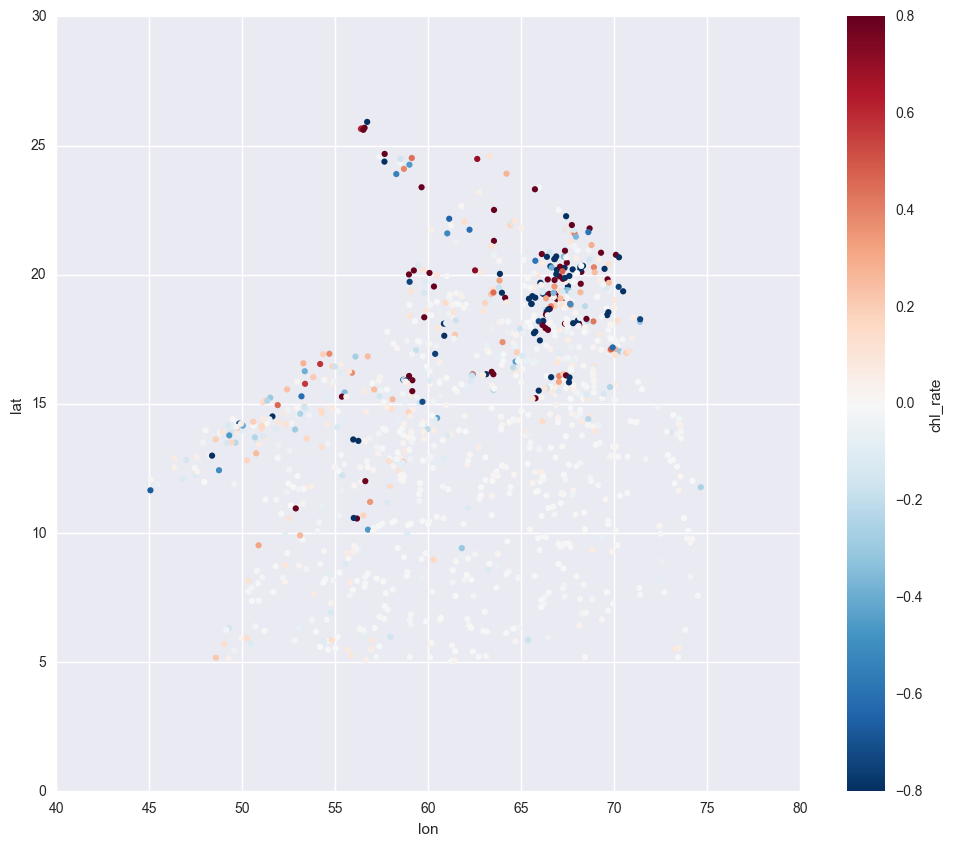

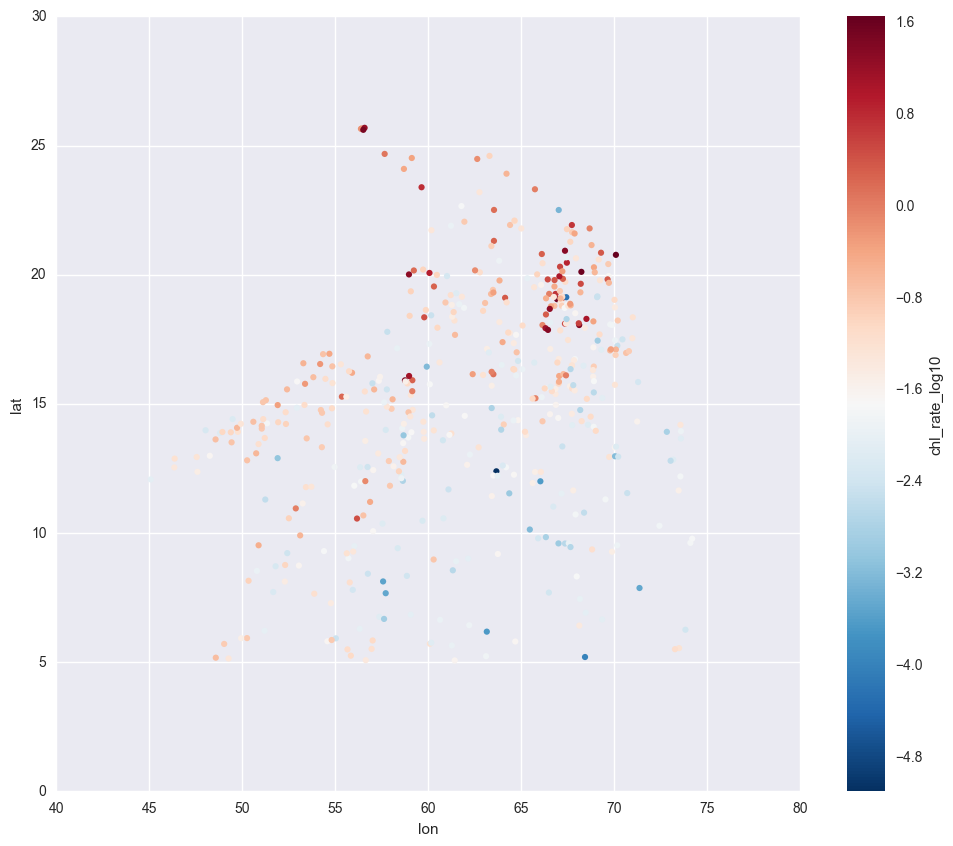

In [82]:
# prepare the data in dataset and about to take the diff
tmp = xr.Dataset.from_dataframe(floatsDFAll_2Dtimeorder.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
# take the diff on the chlor_a
chlor_a_rate = tmp.diff(dim='time',n=1).chlor_a.to_series().reset_index()
# make the column to a proper name
chlor_a_rate.rename(columns={'chlor_a':'chl_rate'}, inplace='True')
chlor_a_rate


# merge the two dataframes {floatsDFAll_2Dtimeorder; chlor_a_rate} into one dataframe based on the index {id, time} and use the left method
floatsDFAllRate_2Dtimeorder=pd.merge(floatsDFAll_2Dtimeorder,chlor_a_rate, on=['time','id'], how = 'left')
floatsDFAllRate_2Dtimeorder

# check 
print('check the sum of the chlor_a before the merge', chlor_a_rate.chl_rate.sum())
print('check the sum of the chlor_a after the merge',floatsDFAllRate_2Dtimeorder.chl_rate.sum())


# visualize the chlorophyll rate, it is *better* to visualize at this scale
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAllRate_2Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r', vmin=-0.8, vmax=0.8, edgecolor='none', ax=ax)

# visualize the chlorophyll rate on the log scale
floatsDFAllRate_2Dtimeorder['chl_rate_log10'] = floatsDFAllRate_2Dtimeorder['chl_rate'].apply(scale)
floatsDFAllRate_2Dtimeorder
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAllRate_2Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chl_rate_log10', cmap='RdBu_r', edgecolor='none', ax=ax)
#floatsDFAllRate_2Dtimeorder.chl_rate.dropna().shape   #  (1104,) data points..... 
floatsDFAllRate_2Dtimeorder.chl_rate_log10.dropna().shape   #  (488,) data points..... notice, chl_rate can be negative, so do not take log10

In [83]:
#from datetime import datetime
#datetime(floatsDFAllRate_2Dtimeorder.time)

pd.to_datetime(floatsDFAllRate_2Dtimeorder.time)
type(pd.to_datetime(floatsDFAllRate_2Dtimeorder.time))
ts = pd.Series(0, index=pd.to_datetime(floatsDFAllRate_2Dtimeorder.time) ) # creat a target time series for masking purpose

# take the month out
month = ts.index.month 
# month.shape # a check on the shape of the month.
selector = ((11==month) | (12==month) | (1==month) | (2==month) | (3==month) )  
selector
print('shape of the selector', selector.shape)

print('all the data count in [11-01, 03-31]  is', floatsDFAllRate_2Dtimeorder[selector].chl_rate.dropna().shape) # total (805,)
print('all the data count is', floatsDFAllRate_2Dtimeorder.chl_rate.dropna().shape )   # total (1104,)

shape of the selector (662004,)
all the data count in [11-01, 03-31]  is (805,)
all the data count is (1104,)


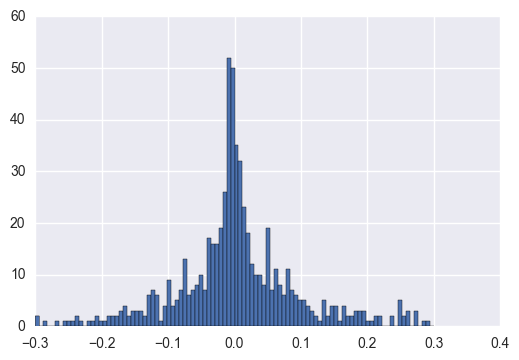

In [84]:
# histogram for non standarized data
floatsDFAllRate_2Dtimeorder[selector].chl_rate.dropna().hist(bins=100,range=[-0.3,0.3]) 

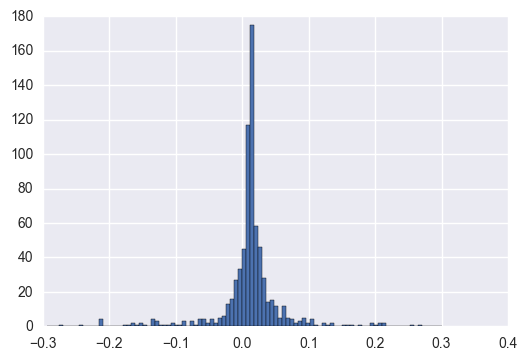

In [85]:
# standarized series
ts = floatsDFAllRate_2Dtimeorder[selector].chl_rate.dropna()
ts_standardized = (ts - ts.mean())/ts.std()
ts_standardized.hist(bins=100,range=[-0.3,0.3])

(52,)
(60,)
(4,)
(49,)
(97,)
(79,)
(145,)
(46,)
(58,)
(13,)
(37,)
(58,)
(233,)
(125,)
(44,)


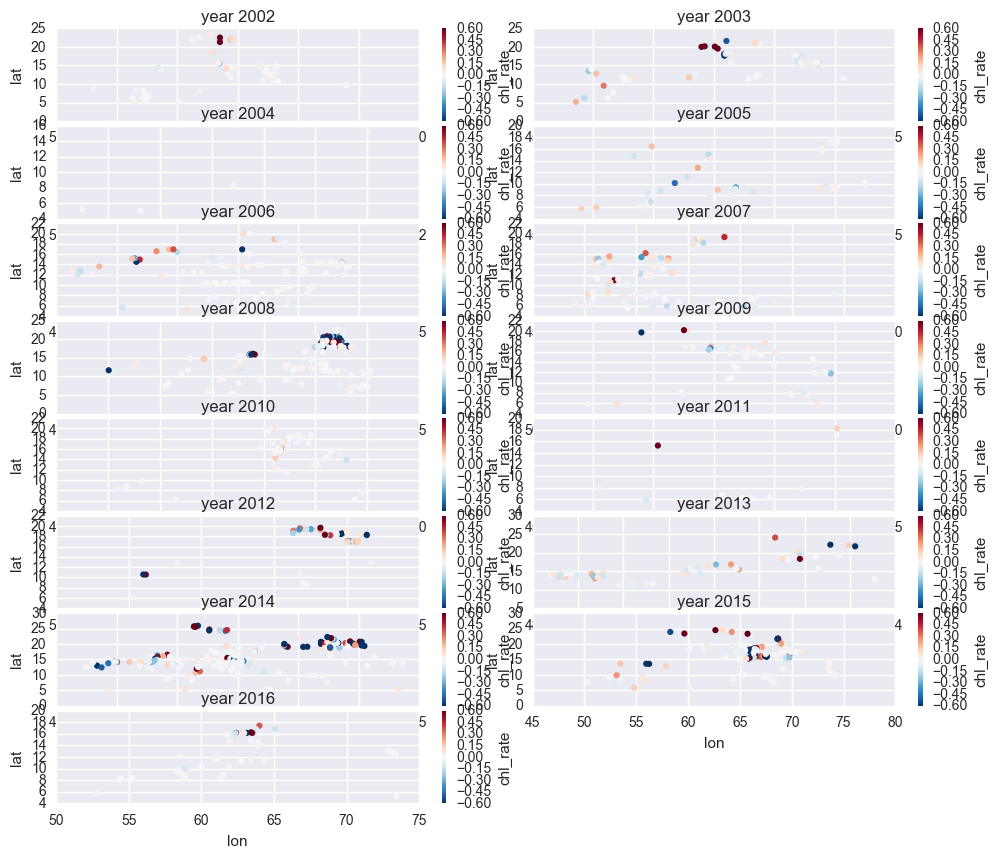

In [86]:
# all the data
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, ax in zip(range(2002,2017), axes.flat) :
    tmpyear = floatsDFAllRate_2Dtimeorder[ (floatsDFAllRate_2Dtimeorder.time > str(i))  & (floatsDFAllRate_2Dtimeorder.time < str(i+1)) ] # if year i
    #fig, ax  = plt.subplots(figsize=(12,10))
    print(tmpyear.chl_rate.dropna().shape)   # total is 1056
    tmpyear.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r',vmin=-0.6, vmax=0.6, edgecolor='none', ax=ax)
    ax.set_title('year %g' % i)     
    

# remove the extra figure
ax = plt.subplot(8,2,16)
fig.delaxes(ax)

(82,)
(1,)
(9,)
(76,)
(35,)
(132,)
(32,)
(46,)
(3,)
(37,)
(0,)
(176,)
(126,)
(50,)


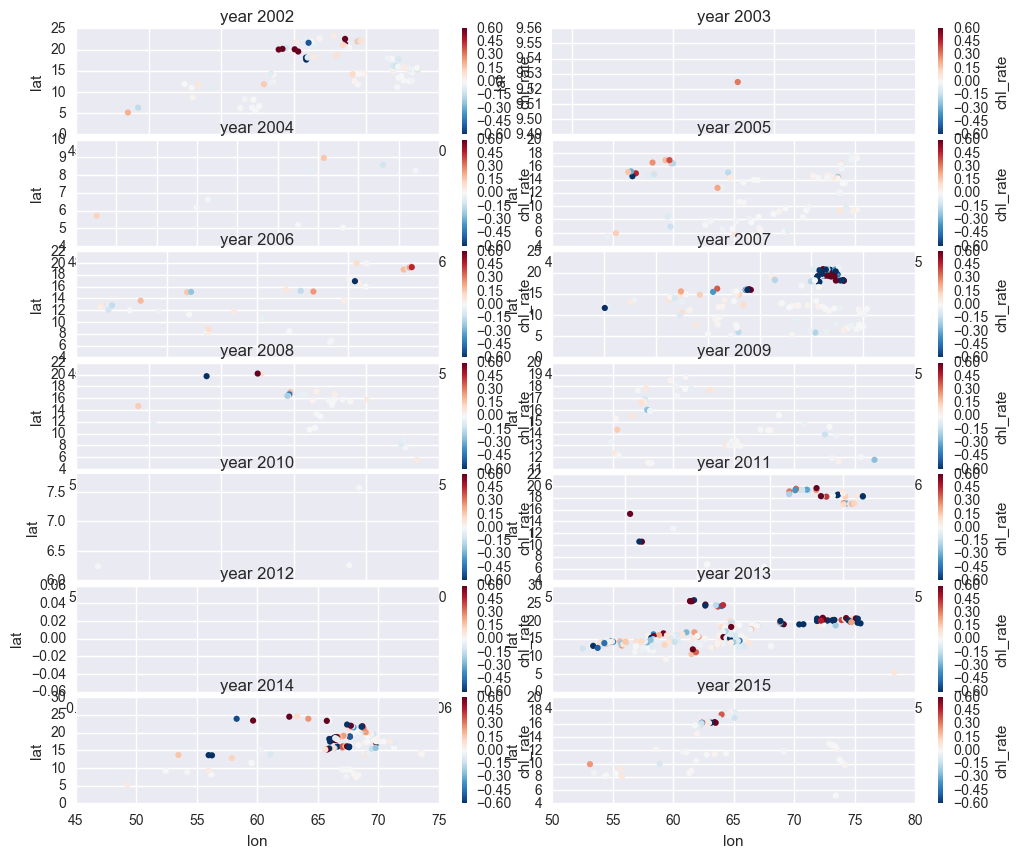

In [87]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, ax in zip(range(2002,2016), axes.flat) :
    tmpyear = floatsDFAllRate_2Dtimeorder[ (floatsDFAllRate_2Dtimeorder.time >= (str(i)+ '-11-01') )  & (floatsDFAllRate_2Dtimeorder.time <= (str(i+1)+'-03-31') ) ] # if year i
    # select only particular month, Nov 1 to March 31
    #fig, ax  = plt.subplots(figsize=(12,10))
    print(tmpyear.chl_rate.dropna().shape)  # the total is 805
    tmpyear.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r', vmin=-0.6, vmax=0.6, edgecolor='none', ax=ax)
    ax.set_title('year %g' % i)  
    
# remove the extra figure
# ax = plt.subplot(8,2,16)
# fig.delaxes(ax)

In [88]:
# let's output the data as a csv or hdf file to disk to save the experiment time

df_list = []
for i in range(2002,2017) :
    tmpyear = floatsDFAllRate_2Dtimeorder[ (floatsDFAllRate_2Dtimeorder.time >= (str(i)+ '-11-01') )  & (floatsDFAllRate_2Dtimeorder.time <= (str(i+1)+'-03-31') ) ] # if year i
    # select only particular month, Nov 1 to March 31
    df_list.append(tmpyear)
    
df_tmp = pd.concat(df_list)
print('all the data count in [11-01, 03-31]  is ', df_tmp.chl_rate.dropna().shape) # again, the total is (805,)
df_chl_out_2D_modisa = df_tmp[~df_tmp.chl_rate.isnull()] # only keep the non-nan values
#list(df_chl_out_2D.groupby(['id']))   # can see the continuity pattern of the Lagarangian difference for each float id

# output to a csv or hdf file
df_chl_out_2D_modisa.head()

all the data count in [11-01, 03-31]  is  (805,)


id       time        lon         ve         vn       temp  \
15828  34721 2002-11-03  67.570000   3.303000   2.865500  29.435500   
16081  34710 2002-11-05  63.160750   0.491500  10.219250  28.991250   
16320  11089 2002-11-07  64.835375 -15.401500   2.263500  28.939625   
16322  15707 2002-11-07  67.399125 -19.144750 -21.695125        NaN   
16336  34315 2002-11-07  57.375375 -49.749875   4.788500  29.647125   

             spd      var_tmp   var_lon        lat   var_lat   chlor_a  \
15828   8.211375     0.001823  0.000135  12.647250  0.000069  0.123307   
16081  10.749875     0.001596  0.000088  17.127000  0.000050  0.445077   
16320  16.392000     0.003391  0.000105  14.366875  0.000056  0.182671   
16322  29.499000  1000.000000  0.000118  13.739500  0.000063  0.161665   
16336  52.729375     0.004589  0.000085   5.613000  0.000048  0.115356   

       chlor_a_log10  chl_rate  chl_rate_log10  
15828      -0.909012 -0.010569             NaN  
16081      -0.351565  0.033500       -1.474955  
16320      -0.738330  0.024246       -1.615360  
16322      -0.791384 -0.004139             NaN  
16336      -0.937960 -0.009359             NaN

In [89]:
df_chl_out_2D_modisa.index.name = 'index'  # make it specific for the index name
df_chl_out_2D_modisa.head()

id       time        lon         ve         vn       temp  \
index                                                                 
15828  34721 2002-11-03  67.570000   3.303000   2.865500  29.435500   
16081  34710 2002-11-05  63.160750   0.491500  10.219250  28.991250   
16320  11089 2002-11-07  64.835375 -15.401500   2.263500  28.939625   
16322  15707 2002-11-07  67.399125 -19.144750 -21.695125        NaN   
16336  34315 2002-11-07  57.375375 -49.749875   4.788500  29.647125   

             spd      var_tmp   var_lon        lat   var_lat   chlor_a  \
index                                                                    
15828   8.211375     0.001823  0.000135  12.647250  0.000069  0.123307   
16081  10.749875     0.001596  0.000088  17.127000  0.000050  0.445077   
16320  16.392000     0.003391  0.000105  14.366875  0.000056  0.182671   
16322  29.499000  1000.000000  0.000118  13.739500  0.000063  0.161665   
16336  52.729375     0.004589  0.000085   5.613000  0.000048  0.115356   

       chlor_a_log10  chl_rate  chl_rate_log10  
index                                           
15828      -0.909012 -0.010569             NaN  
16081      -0.351565  0.033500       -1.474955  
16320      -0.738330  0.024246       -1.615360  
16322      -0.791384 -0.004139             NaN  
16336      -0.937960 -0.009359             NaN

In [90]:
# CSV CSV CSV CSV with specfic index
df_chl_out_2D_modisa.to_csv('df_chl_out_2D_modisa.csv', sep=',', index_label = 'index')

# load CSV output
test = pd.read_csv('df_chl_out_2D_modisa.csv', index_col='index')

# a check
test.head()

id        time        lon         ve         vn       temp  \
index                                                                  
15828  34721  2002-11-03  67.570000   3.303000   2.865500  29.435500   
16081  34710  2002-11-05  63.160750   0.491500  10.219250  28.991250   
16320  11089  2002-11-07  64.835375 -15.401500   2.263500  28.939625   
16322  15707  2002-11-07  67.399125 -19.144750 -21.695125        NaN   
16336  34315  2002-11-07  57.375375 -49.749875   4.788500  29.647125   

             spd      var_tmp   var_lon        lat   var_lat   chlor_a  \
index                                                                    
15828   8.211375     0.001823  0.000135  12.647250  0.000069  0.123307   
16081  10.749875     0.001596  0.000088  17.127000  0.000050  0.445077   
16320  16.392000     0.003391  0.000105  14.366875  0.000056  0.182671   
16322  29.499000  1000.000000  0.000118  13.739500  0.000063  0.161665   
16336  52.729375     0.004589  0.000085   5.613000  0.000048  0.115356   

       chlor_a_log10  chl_rate  chl_rate_log10  
index                                           
15828      -0.909012 -0.010569             NaN  
16081      -0.351565  0.033500       -1.474955  
16320      -0.738330  0.024246       -1.615360  
16322      -0.791384 -0.004139             NaN  
16336      -0.937960 -0.009359             NaN

In [91]:
# HDF HDF HDF HDF
# deprecated!
'''
df_chl_out_2D.to_hdf('df_chl_out_2D.h5','df_chl_out_2D')

# load HDF5 output
test = pd.read_hdf('df_chl_out_2D.h5')

# a check
test.head()
'''

"\ndf_chl_out_2D.to_hdf('df_chl_out_2D.h5','df_chl_out_2D')\n\n# load HDF5 output\ntest = pd.read_hdf('df_chl_out_2D.h5')\n\n# a check\ntest.head()\n"

# Should we remove nan values in the interpolation steps?

In [ ]:
# the question is: is the chlorophyll_ocx negatively correlated with the temperature?
# how many nans in the chlor_a, what's the percentage of nans

# first, do a resampling on the floater data onto the two days frequency
# second, dump the dataframe into a dataset 
# third, do the diff to get the rate of change in xarray
# fourth, plot the rate of changes for different years!!


# add the oxygen, add the salinity, add strain, add stress, add vorticity
